<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> # Earth Satellites
>
> Skyfield is able to predict the positions of Earth satellites by loading satellite orbital elements from Two-Line Element (TLE) files — published by organizations like CelesTrak — and running them through the SGP4 satellite propagation routine. 


In [18]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import h5py
import os

from skyfield.api import load, wgs84

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE file
>
> Skyfield loader objects offer a tle_file() method that can download and cache a file full of satellite elements from a site like Celestrak. A popular observing target for satellite observers is the International Space Station, which is listed in Celestrak’s stations.txt file:

In [19]:
stations_url = 'https://celestrak.com/NORAD/elements/weather.txt'


satellites = load.tle_file(stations_url, reload=False)

by_name = {sat.name: sat for sat in satellites}
satellite = by_name['METOP-A']

print(satellite)

METOP-A catalog #29499 epoch 2021-12-07 21:43:58 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE set from strings
> If your program already has the two lines of TLE data for a satellite and doesn’t need Skyfield to download and parse a Celestrak file, you can instantiate an EarthSatellite directly.

In [20]:
from skyfield.api import EarthSatellite

ts = load.timescale()
line1 = '1 38771U 12049A   21328.15653177  .00000019  00000+0  28851-4 0  9990'
line2 = '2 38771  98.6954  26.0543 0000110 196.3188 189.2859 14.21494351476561'

satellite = EarthSatellite(line1, line2, 'METOP-B', ts)

print(ts)
print(satellite)

METOP-B catalog #38771 epoch 2021-11-24 03:45:24 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Satellite altitude, azimuth, and distance
>
> You might be most interested in whether the satellite is above or below the horizon from your own position as an observer, and in which direction to look for it. If you build an object to represent your latitude and longitude , you can use vector subtraction to ask “where will the satellite be relative to my location?”

In [21]:

LLN = wgs84.latlon(50.67, 4.61)

difference = satellite - LLN

dates = pd.date_range("2020-01-01","2021-01-01",freq='60S')
alt = np.zeros(np.size(dates)) * np.nan
az = np.zeros(np.size(dates)) * np.nan
distance = np.zeros(np.size(dates)) * np.nan

for ii,date in enumerate(dates):

    t = ts.utc(date.year, date.month, date.day, date.hour, date.minute, date.second)

    topocentric = difference.at(t)

    alt_, az_, distance_ = topocentric.altaz()

    alt[ii] = alt_.degrees
    az[ii] = az_.degrees
    distance[ii] = distance_.km

df = pd.DataFrame(index = dates)

# ind = np.nonzero(alt<5)

# alt[ind] = np.nan
# az[ind] = np.nan 

df['EL'] = alt 
df['AZ'] = az 
df['DISTANCE'] = distance



KeyboardInterrupt: 

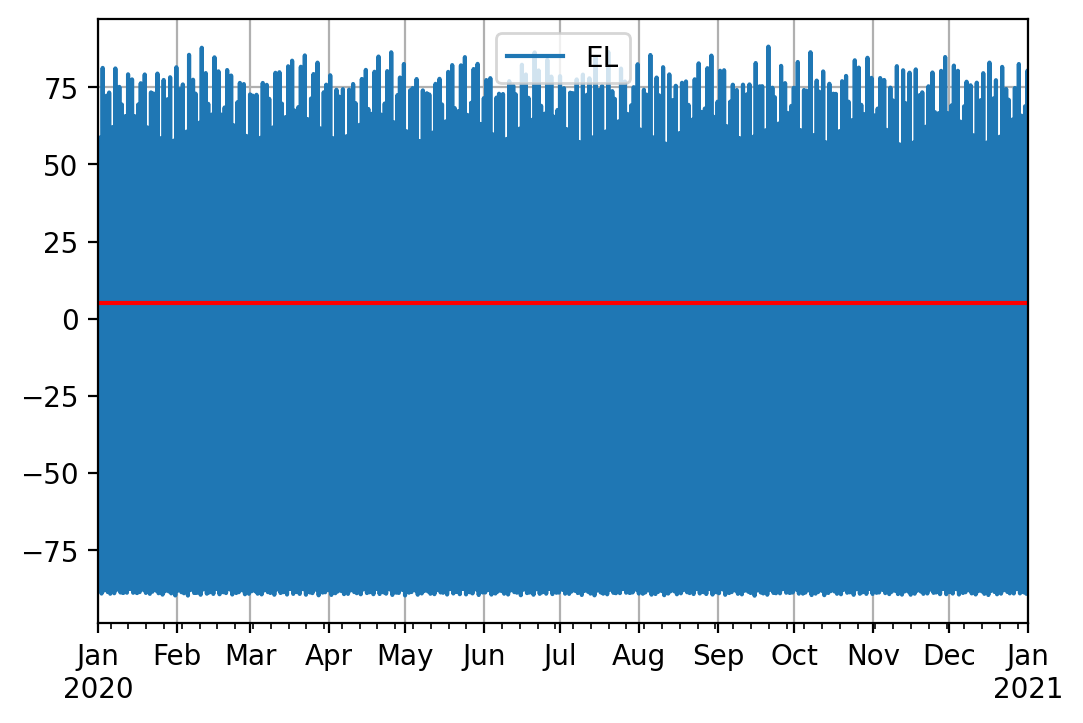

In [ ]:

fig, ax = plt.subplots(dpi=200)
ax = df.plot(ax=ax, y='EL', linestyle='solid', marker='')

ax.grid(b=True, which='major', axis='both')
ax.axhline(y=5, color='r', linestyle='-')

plt.show()

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Probability density function of LEO satellite visibility
>
> In this section the probability density function for elevation angle will be calculated $P(\theta)$

In [ ]:
stp = 5
bins = np.arange(5,91,stp)

stat = pd.DataFrame(index=bins)

for bin in bins:
    ind  = np.logical_and( bin <= df['EL'] , df['EL'] < bin+stp)

    el = df.loc[ind,'EL']

    stat.loc[bin,'PDF'] = np.size(el)/np.size(ind)

stat['PDF'] = stat['PDF']/stat['PDF'].sum() * 100
# stat['PDF'] = stat['PDF']/1 * 100

fig = px.bar(stat, y='PDF')

fig.update_layout(font_family="FreeSerif",
                font_color="black")

fig.show()



<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Load RAPIDS II Data
>
> In this section different type of attenuation from RAPIDS II are imported and saved in pandas DataFrame format.
> The rapids II data are in two `csv` file corresponds to different elevation angle. One is for $\theta = 5,10,...,50$ and the other is for the elevation angles $\theta=55,...,90$
>
> **Be Carefull** : to enter your `csv` files please change and edit the file manually according to this example.

In [ ]:
rapids = pd.read_csv("attenuation_total_01.csv")

rapids = rapids.append(pd.read_csv("attenuation_total_02.csv"))

fig = px.line(rapids, x='PROBABILITY', y='ATTENUATION', color='ELEVATION', log_x=True)

fig.show()

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Change GEO to LEO statistics
>
> In this section the statistics of the total attenuation of GEO satellite is changed to LEO statistics. To achieve this goal below conditional probability is usefull
>
\begin{equation}
P(A>A_0) = \sum_{\theta} P(A>A_0 | \theta) P(\theta)
\end{equation}
>
> Which $P(\theta)$ is the probability ocurence of the LEO satellite in elevation angle $\theta$. The variable $P(\theta)$ is calculated in section `Probability density function of LEO satellite visibility`
>
> Above summation should be done for each static attenuation. Then by considering constant attenuation, the related probability is achieved by interpolation.

In [ ]:
Attenuation = np.arange(0,300, step=2)

LEO = pd.DataFrame(index=Attenuation)

for att in Attenuation:
    P = 0
    for theta in stat.index:
        rapids_query = rapids[rapids.ELEVATION==theta] 

        fcn =  interp1d(rapids_query['ATTENUATION'].to_numpy(), rapids_query['PROBABILITY'].to_numpy(),kind='linear', bounds_error=False, fill_value=(100,0))

        P = P + fcn(att) * stat.loc[theta, 'PDF'] / 100

    LEO.loc[att,'PROBABILITY'] = P


LEO = LEO.dropna()

LEO['ATTENUATION'] = LEO.index.to_series()

LEO = LEO.reset_index()

fig = px.scatter(LEO, x='PROBABILITY', y='ATTENUATION', log_x=True)

fig.show()



<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Link Budget
>
> In this section the link budget for different time exceed of the avaialbility is plotted. Be carefull to change the parameter acording to your text description. 
> 
> remember to calculate the mean average of `Earth-satellite mean distance [meter]` using the procedure in `https://rhodesmill.org/skyfield/earth-satellites.html`.
> The ditance between ground station and satellite is calculated in earlier section. Just find the mean value of the distance and fill in below box.

In [17]:
k = 1.381e-23    # boltzman constant
B = 50 # Receiver bandwidth [Hz]
T = 500 # Kelvin

N = 10*np.log10(k * T * B)  # Noise level

SNR = 10     # signal to noise ratio [dB]

fr = ??  # frequency GHz
lamda = ?? # wavelength [meter]
r =  ?? # Earth-satellite mean distance [meter]

L_0 = ?? # free space loss [dB]
L_atm = ??       # Atmospheric attenuation for every probability [dB]
L_misc = ??  # Micellaneous loss [dB]


L = ??  # total path loss

Gr = 51.0  # Receive antenna gain [dB]

LEO['EIRP'] = SNR + N + L - Gr

fig = px.scatter(LEO, x='PROBABILITY', y='EIRP', log_x=True)

fig.add_vline(x=1, line_width=3, line_dash="dash", line_color="red")
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x=0.1, line_width=3, line_dash="dash", line_color="yellow")
fig.add_vline(x=0.01, line_width=3, line_dash="dash", line_color="orange")

fig.show()


209.00800125578616
